In [1]:
# Set your API Endpoint
# ?\You can load a list of configurations from an environment variable or a json file.

from autogen.agentchat import UserProxyAgent,AssistantAgent,GroupChat,GroupChatManager
import os
from dotenv import load_dotenv

load_dotenv()

config_list_gpt4 = [{"model": "gpt-4o", "api_key": os.getenv('OPENAI_API_KEY')}]

In [2]:
gpt4_config = {
    "cache_seed": 42,  # change the cache_seed for different trials
    "temperature": 0,
    "config_list": config_list_gpt4,
    "timeout": 120,
}

In [3]:
# Construct Agents
# Let's build our team, this code is setting up a system of agents using the autogen library. The agents include a human admin, an AI Developer, a scientist, a planner, an executor, and a quality assurance agent. Each agent is configured with a name, a role, and specific behaviors or responsibilities.

# User Proxy Agent  
user_proxy = UserProxyAgent(  
    name="Admin",  
    human_input_mode="ALWAYS",  
    system_message="1. A human admin. 2. Interact with the team. 3. Plan execution needs to be approved by this Admin.",  
    code_execution_config=False,  
    llm_config=gpt4_config,  
    description="""Call this Agent if:   
        You need guidance.
        The program is not working as expected.
        You need api key                  
        DO NOT CALL THIS AGENT IF:  
        You need to execute the code.""",  
)  
  
# Assistant Agent - Developer  
developer = AssistantAgent(  
    name="Developer",  
    llm_config=gpt4_config,  
    system_message="""You are an AI developer. You follow an approved plan, follow these guidelines: 
    1. You write python/shell code to solve tasks. 
    2. Wrap the code in a code block that specifies the script type.   
    3. The user can't modify your code. So do not suggest incomplete code which requires others to modify.   
    4. You should print the specific code you would like the executor to run.
    5. Don't include multiple code blocks in one response.   
    6. If you need to import libraries, use ```bash pip install module_name```, please send a code block that installs these libraries and then send the script with the full implementation code 
    7. Check the execution result returned by the executor,  If the result indicates there is an error, fix the error and output the code again  
    8. Do not show appreciation in your responses, say only what is necessary.    
    9. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
    """,  
    description="""Call this Agent if:   
        You need to write code.                  
        DO NOT CALL THIS AGENT IF:  
        You need to execute the code.""",  
)  
# Assistant Agent - Planner  
planner = AssistantAgent(  
    name="Planner",  #2. The research should be executed with code
    system_message="""You are an AI Planner,  follow these guidelines: 
    1. Your plan should include 5 steps, you should provide a detailed plan to solve the task.
    2. Post project review isn't needed. 
    3. Revise the plan based on feedback from admin and quality_assurance.   
    4. The plan should include the various team members,  explain which step is performed by whom, for instance: the Developer should write code, the Executor should execute code, important do not include the admin in the tasks e.g ask the admin to research.  
    5. Do not show appreciation in your responses, say only what is necessary.  
    6. The final message should include an accurate answer to the user request
    """,  
    llm_config=gpt4_config,  
    description="""Call this Agent if:   
        You need to build a plan.                  
        DO NOT CALL THIS AGENT IF:  
        You need to execute the code.""",  
)  
  
# User Proxy Agent - Executor  
executor = UserProxyAgent(  
    name="Executor",  
    system_message="1. You are the code executer. 2. Execute the code written by the developer and report the result.3. you should read the developer request and execute the required code",  
    human_input_mode="NEVER",  
    code_execution_config={  
        "last_n_messages": 20,  
        "work_dir": "dream",  
        "use_docker": True,  
    },  
    description="""Call this Agent if:   
        You need to execute the code written by the developer.  
        You need to execute the last script.  
        You have an import issue.  
        DO NOT CALL THIS AGENT IF:  
        You need to modify code""",
)
quality_assurance = AssistantAgent(
    name="Quality_assurance",
    system_message="""You are an AI Quality Assurance. Follow these instructions:
      1. Double check the plan, 
      2. if there's a bug or error suggest a resolution
      3. If the task is not solved, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach.""",
    llm_config=gpt4_config,
)

In [8]:
# Group chat is a powerful conversation pattern, but it can be hard to control if the number of participating agents is large. 
# AutoGen provides a way to constrain the selection of the next speaker by using the allowed_or_disallowed_speaker_transitions argument of the GroupChat class.
allowed_transitions = {
    user_proxy: [ planner,quality_assurance],
    planner: [ user_proxy, developer, quality_assurance],
    developer: [executor,quality_assurance, user_proxy],
    executor: [developer],
    quality_assurance: [planner,developer,executor,user_proxy],
}

In [5]:
system_message_manager="You are the manager of a research group your role is to manage the team and make sure the project is completed successfully."
groupchat = GroupChat(
    agents=[user_proxy, developer, planner, executor, quality_assurance],allowed_or_disallowed_speaker_transitions=allowed_transitions,
    speaker_transitions_type="allowed", messages=[], max_round=30,send_introductions=True
)
manager = GroupChatManager(groupchat=groupchat, llm_config=gpt4_config, system_message=system_message_manager)

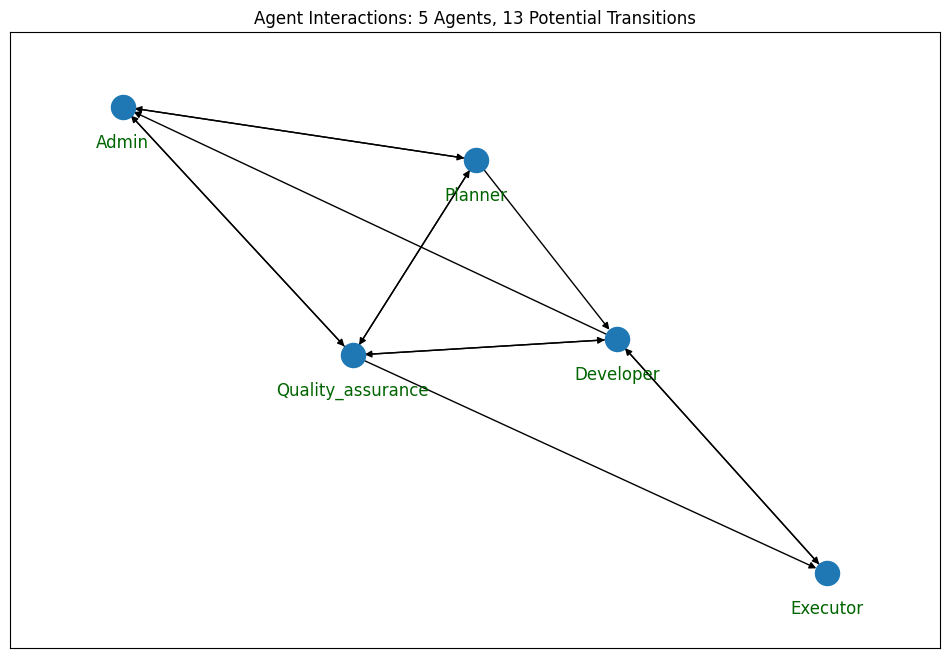

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes
G.add_nodes_from([agent.name for agent in groupchat.agents])

# Add edges
for key, value in allowed_transitions.items():
    for agent in value:
        G.add_edge(key.name, agent.name)

# Set the figure size
plt.figure(figsize=(12, 8))

# Visualize
pos = nx.spring_layout(G)  # For consistent positioning

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# Draw labels below the nodes
label_pos = {k: [v[0], v[1] - 0.1] for k, v in pos.items()}  # Shift labels below the nodes
nx.draw_networkx_labels(G, label_pos, verticalalignment='top', font_color="darkgreen")

# Adding margins
ax = plt.gca()
ax.margins(0.1)  # Increase the margin value if needed


# Adding a dynamic title
total_transitions = sum(len(v) for v in allowed_transitions.values())
title = f'Agent Interactions: {len(groupchat.agents)} Agents, {total_transitions} Potential Transitions'
plt.title(title)

plt.show()

In [9]:
# Start Chat
task1="what are the 5 leading GitHub repositories on llm for the legal domain?"
chat_result=user_proxy.initiate_chat(
    manager,
    message=task1
, clear_history=True
)

Admin (to chat_manager):

what are the 5 leading GitHub repositories on llm for the legal domain?

--------------------------------------------------------------------------------

Next speaker: Planner

Planner (to chat_manager):

To identify the 5 leading GitHub repositories on large language models (LLM) for the legal domain, we will follow a structured plan:

1. **Research and Identification**  
   - **Team Member**: Developer  
   - **Task**: Conduct research on GitHub to identify repositories related to large language models in the legal domain. Use search terms like "LLM legal", "legal AI", "legal NLP", etc. to find relevant repositories. 

2. **Criteria Definition**  
   - **Team Member**: Planner  
   - **Task**: Define criteria for what makes a repository "leading". This could include factors such as the number of stars, forks, recent activity, and community engagement.

3. **Repository Evaluation**  
   - **Team Member**: Developer  
   - **Task**: Evaluate the identified re

In [10]:
import pprint
pprint.pprint(chat_result.cost)
pprint.pprint(chat_result.summary)
pprint.pprint(chat_result.chat_history)

{'usage_excluding_cached_inference': {'total_cost': 0},
 'usage_including_cached_inference': {'total_cost': 0}}
('It seems there is a persistent issue with setting the environment variable. '
 "Let's ensure the steps are clear and correct for your specific operating "
 'system. \n'
 '\n'
 '### For Linux/MacOS (Bash Terminal):\n'
 '1. Open your terminal.\n'
 '2. Set the environment variable using:\n'
 '   ```bash\n'
 "   export GITHUB_ACCESS_TOKEN='your_access_token_here'\n"
 '   ```\n'
 '3. Verify it with:\n'
 '   ```bash\n'
 '   echo $GITHUB_ACCESS_TOKEN\n'
 '   ```\n'
 '\n'
 '### For Windows (Command Prompt):\n'
 '1. Open Command Prompt.\n'
 '2. Set the environment variable using:\n'
 '   ```cmd\n'
 '   set GITHUB_ACCESS_TOKEN=your_access_token_here\n'
 '   ```\n'
 '3. Verify it with:\n'
 '   ```cmd\n'
 '   echo %GITHUB_ACCESS_TOKEN%\n'
 '   ```\n'
 '\n'
 '### For Windows (PowerShell):\n'
 '1. Open PowerShell.\n'
 '2. Set the environment variable using:\n'
 '   ```powershell\n'
 "   